In [1]:
from pathlib import Path

is_colab = False  # if run in colab set this true

In [2]:
# setup the environment


if is_colab:

    from google.colab import drive
    drive.mount('/content/gdrive')

    path_root = Path('/content/gdrive/My Drive/Colab Notebooks/')

    # install the pynvcenter package from github
    !pip install git+https://github.com/JanGieseler/pynvcenter.git



    from keras import backend as K
    print(K.tensorflow_backend._get_available_gpus())
else:
    path_root = Path('../')

    # for the local version we assume that pynvcenter is located in the parent dir of the notebook
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

path_ipynb = path_root/'notebooks'
path_data = path_root/'data'
path_model = path_root/'models'
path_html = path_root/'html'

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

from sklearn.externals import joblib

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import json
import matplotlib.pyplot as plt


from matplotlib.patches import Rectangle

%matplotlib inline

from tqdm import tqdm


from pynvcenter.nv_analysis import esr_ring_scan_freqs, fit_arc, loss_arcs

import h5py
%load_ext autoreload
%autoreload 2
from keras.models import load_model

from glob import glob

import matplotlib 

from IPython.display import display, Markdown

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=10) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from pynvcenter.nn_utils import *

## show the experimental data
### define inputs (filenames, calibration, etc.)

#### From 190123

In [5]:
# filename_esr = '../data_exp/190122-15_41_20_esr_many_on_alice_wider_range_center_0_0_esr_map.h5'
# filename_pos = '../data_exp/190122-15_40_40_select_points'


filename_pos = '../data_exp/190123-19_32_44_select_points'

filename_esr = '../data_exp/190123-19_39_47_esr_many_on_alice_wider_range_center_0_0'




freq_center = 2870000000.0
freq_range = 500000000.0


calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
esr_map = np.array(h5f['esr_map'])
frequencies = np.array(h5f['frequency'])
h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))

the calibration factor is 659.259 micrometers / volt
frequencies from 2.620GHz - 3.120GHz


#### From 190125

In [552]:
filename_pos = '../data_exp/190125-21_00_31_select_points'

filenames_esr = [
    '../data_exp/190125-21_01_46_esr_many_on_alice_wider_range_center_0_0',
    '../data_exp/190127-18_08_52_esr_many_on_alice_wider_range_center_0_0'
                ]

freq_center = 2870000000.0
freq_range = 500000000.0


img_dims = [50, 200]

calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

esr_map = None
for filename_esr in filenames_esr:
    print(filename_esr)
    h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
    
    if esr_map is None:
        esr_map = np.array(h5f['esr_map'])
    else:
        esr_map += np.array(h5f['esr_map'])
    frequencies = np.array(h5f['frequency'])
    h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))
esr_map /=len(filenames_esr)

the calibration factor is 659.259 micrometers / volt
../data_exp/190125-21_01_46_esr_many_on_alice_wider_range_center_0_0
../data_exp/190127-18_08_52_esr_many_on_alice_wider_range_center_0_0
frequencies from 2.620GHz - 3.120GHz


In [553]:
# def pad_esr_map(frequencies, angles, esr_map, img_dims):


#     padding_dims = [d-s for s, d in zip(esr_map.shape, img_dims)]
#     print('typically we expect to cut off the image along the frequency dimension and pad it in the angle dimension')
#     assert padding_dims[0]>=0
#     assert padding_dims[1]<=0
#     padding_dims = [[p//2, p-p//2] for p in padding_dims]  # calculate the padding dims for the left/right, up/down
#     padding_dims[1] = [-padding_dims[1][0]-1, esr_map.shape[1]+padding_dims[1][0]] # for the freq we actually want the range
#     esr_map = np.vstack([esr_map[-padding_dims[0][0]:], esr_map, esr_map[0:padding_dims[0][1]]])
#     esr_map = esr_map[:,padding_dims[1][0]:padding_dims[1][1]]
    
#     angles = np.hstack([angles[-padding_dims[0][0]:]-360, angles, 360+angles[0:padding_dims[0][1]]])
#     frequencies = frequencies[padding_dims[1][0]:padding_dims[1][1]]
#     return frequencies, angles, esr_map

# # f, a, e = pad_esr_map(frequencies, angles, esr_map, img_dims)
# # print(e.shape)  
# # plt.pcolor(f, a, e)
# # img_dims[0]//2, img_dims[0]//2

(45, 251)


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


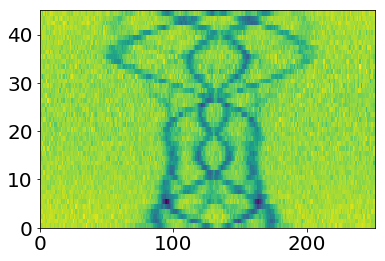

In [554]:
print(esr_map.shape)

plt.pcolor(esr_map)

import scipy.misc
scipy.misc.imsave('outfile.jpg', esr_map)

**esr radius:	 72.433 micrometers**

image dimensions:  (45, 251)


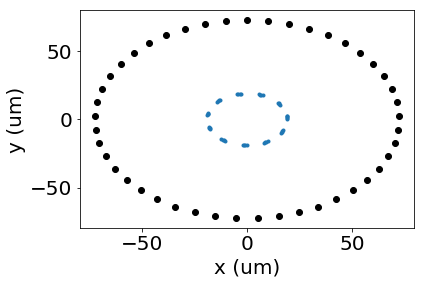

In [555]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um
angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad

nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
display(Markdown('**esr radius:\t {:0.3f} micrometers**'.format(radius)))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

print('image dimensions: ', esr_map.shape)

In [556]:
noise_region = {'fmin':2.65e9, 'f_range':1e8, 'angle_min':50, 'angle_range':150}

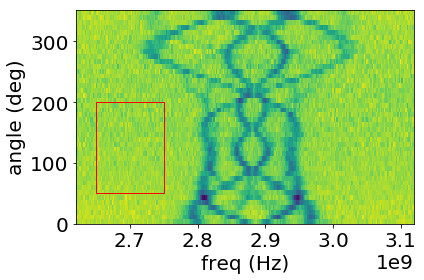

In [557]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

fig.savefig('190125_esp_map.png')

In [558]:
img_dims = [100,200]

In [559]:
# fig=plt.figure()

# Xo = pad_image(esr_map, img_dims=img_dims)
# Xo.shape

# img = Xo-Xo.min()
# img = 255 * img / img.max()
# img = img.astype(np.uint8)

# plt.imshow(img)


# imsave('esr_map_2.jpg', img)

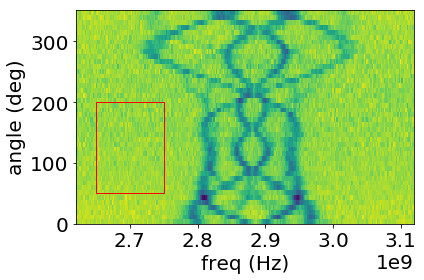

In [560]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

#### from 171222

In [458]:
filename_pos = '../data_exp/171222-11_32_14_select_points'

filenames_esr = [
    '../data_exp/171222-11_33_16_esr_many_pts_ring_around_bead_1'
                ]

freq_center = 2.85e9
freq_range = 0.7e9


img_dims = [50, 200]

calibration_factor = 60  # mu / px * px / V = mu / V

particle_radius = 1.4  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

esr_map = None
for filename_esr in filenames_esr:
    print(filename_esr)
    h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
    
    if esr_map is None:
        esr_map = np.array(h5f['esr_map'])
    else:
        esr_map += np.array(h5f['esr_map'])
    frequencies = np.array(h5f['frequency'])
    h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))
esr_map /=len(filenames_esr)

# limit to the interesting range
print(esr_map.shape)
esr_map = esr_map[:,200:470]
frequencies = frequencies[200:470]

the calibration factor is 60.000 micrometers / volt
../data_exp/171222-11_33_16_esr_many_pts_ring_around_bead_1
frequencies from 2.500GHz - 3.200GHz
(90, 651)


In [459]:
frequencies[0], frequencies[-1]

(2715384615.38, 3005076923.08)

(90, 270)


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


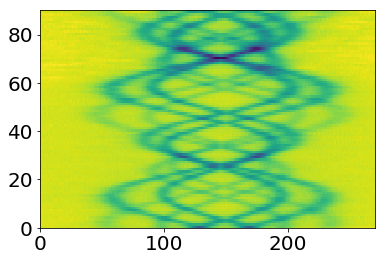

In [460]:
print(esr_map.shape)

plt.pcolor(esr_map)

import scipy.misc
scipy.misc.imsave('outfile.jpg', esr_map)

**esr radius:	 5.180 micrometers**

image dimensions:  (90, 270)


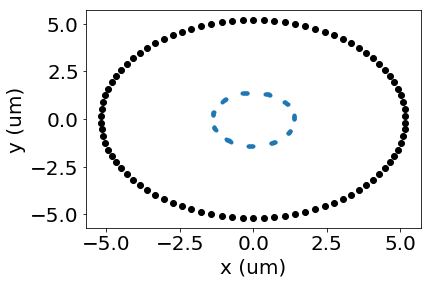

In [461]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um

if os.path.exists(str(filename_pos+ '-angles.csv')):
    angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad
else:
    angles = np.linspace(0,360,esr_map.shape[0]+1)[0:-1]
    
nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
display(Markdown('**esr radius:\t {:0.3f} micrometers**'.format(radius)))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

print('image dimensions: ', esr_map.shape)

In [162]:
noise_region = {'fmin':min(frequencies), 'f_range':0.25e8, 'angle_min':0, 'angle_range':360}

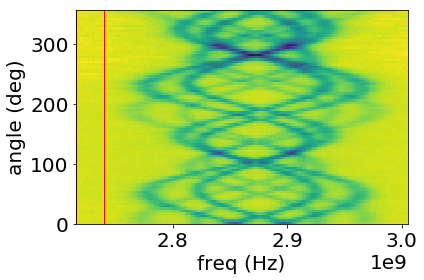

In [163]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

fig.savefig('171222_esr_map.png')

#### from 190216

In [126]:
filename_pos = '../data_exp/190214-13_27_42_select_points'

filenames_esr = [
    '../data_exp/190216-17_49_30_esr_many_RT_bead_moved_moredata'
                ]


img_dims = [50, 200]

calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

esr_map = None
for filename_esr in filenames_esr:
    print(filename_esr)
    h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
    
    if esr_map is None:
        esr_map = np.array(h5f['esr_map'])
    else:
        esr_map += np.array(h5f['esr_map'])
    frequencies = np.array(h5f['frequency'])
    h5f.close()
    
# match frequency range to the simulation data
f_min = 2670000000
f_max = 3068000000
    
# freq_center = 2.85e9
# freq_range = 0.7e9
freq_center = np.mean(frequencies)
freq_range = np.max(frequencies)- np.min(frequencies)
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))
esr_map /=len(filenames_esr)
print(esr_map.shape)

data_selector = np.logical_and(frequencies>=f_min,frequencies<=f_max)

# limit to the interesting range

esr_map = esr_map[:,data_selector]
frequencies = frequencies[data_selector]

freq_center = np.mean(frequencies)
freq_range = np.max(frequencies)- np.min(frequencies)
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))
print(esr_map.shape)

the calibration factor is 659.259 micrometers / volt
../data_exp/190216-17_49_30_esr_many_RT_bead_moved_moredata
frequencies from 2.620GHz - 3.120GHz
(45, 251)
frequencies from 2.670GHz - 3.068GHz
(45, 200)


In [127]:
frequencies.shape

(200,)

(45, 200)


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


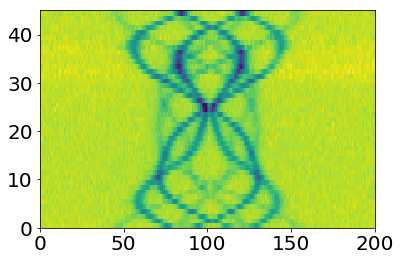

In [128]:
print(esr_map.shape)

plt.pcolor(esr_map)

import scipy.misc
scipy.misc.imsave('outfile.jpg', esr_map)

**esr radius:	 69.530 micrometers**

image dimensions:  (45, 200)


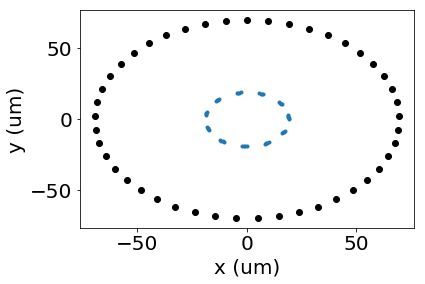

In [129]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um

if os.path.exists(str(filename_pos+ '-angles.csv')):
    angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad
else:
    angles = np.linspace(0,360,esr_map.shape[0]+1)[0:-1]
    
nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
display(Markdown('**esr radius:\t {:0.3f} micrometers**'.format(radius)))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

print('image dimensions: ', esr_map.shape)

In [130]:
noise_region = {'fmin':min(frequencies), 'f_range':0.25e8, 'angle_min':60, 'angle_range':180}

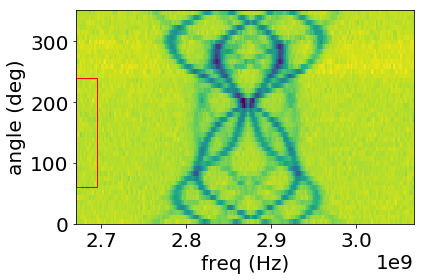

In [131]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

fig.savefig('171222_esr_map.png')

### Look at the noise

The noise is $n = \sqrt{c \tau}$, where $s = c \tau$ are the number of photons collected. Thus, the normalized noise is

$$n_{\rm norm} = n/s =  1 / \sqrt{c \tau}$$,

where $c$ is the count rate and $\tau$ the measurement time.

**noise: 0.10%**

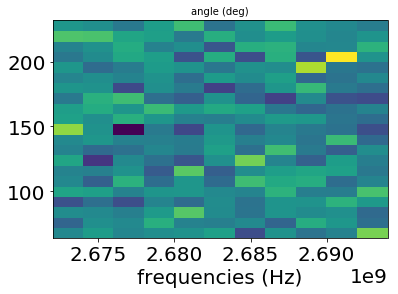

In [132]:
freq_select = np.array(frequencies>noise_region['fmin']) & np.array(frequencies<noise_region['fmin']+noise_region['f_range'])
angle_select = np.array(angles>noise_region['angle_min']) & np.array(angles<noise_region['angle_min']+noise_region['angle_range'])

noise = esr_map[angle_select][:,freq_select]
plt.pcolor(frequencies[freq_select], angles[angle_select], noise)
plt.title('noise')
plt.xlabel('frequencies (Hz)')
plt.title('angle (deg)')
display(Markdown('**noise: {:0.2f}%**'.format(noise.std() / noise.mean() * 100)))


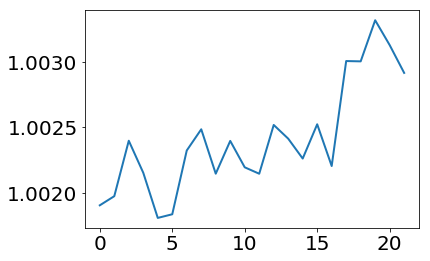

In [33]:
plt.plot(np.mean(noise, axis=1))

### look at the distributions and get SNR

0.05738102302408166


**SNR: 61**

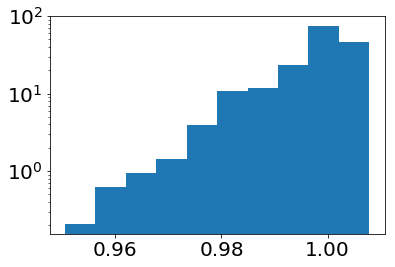

In [34]:
signal = esr_map.max() - esr_map.min()
print(signal)
display(Markdown('**SNR: {:0.0f}**'.format(signal / noise.std())))
plt.hist(esr_map.flatten(), density=True, log=True);

**show available models**

In [564]:
# [f.split('/')[-1].split('_model.h5')[0] for f in glob('../models/*model*.h5')]
list(path_model.glob('*_model*'))

[PosixPath('../models/20190201-1943_sim_data_2_model.h5'),
 PosixPath('../models/20190201-2341_sim_data_3_model.h5'),
 PosixPath('../models/20190209-0505_sim_data_5_model.h5'),
 PosixPath('../models/shot_noise_0_xyztp_model.h5'),
 PosixPath('../models/20190131-1725_sim_data_20190125_model.h5'),
 PosixPath('../models/20190201-0031_sim_data_20190125_model.h5'),
 PosixPath('../models/20190201-2336_sim_data_3_model.h5'),
 PosixPath('../models/20190203-2346_sim_data_4_model.h5')]

## load the model

In [149]:
model_name = '20190203-2346_sim_data_4_model.h5'
model_name = '20190201-2341_sim_data_3_model.h5'
model_name = '20190209-0505_sim_data_5_model.h5'

In [150]:
import keras
print(keras.__version__)
model = load_model(str(path_model/model_name))
# keras.models.load_model(str(path_model/model_name)) 
model.summary()

2.2.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 98, 198, 16)       160       
_________________________________________________________________
activation_34 (Activation)   (None, 98, 198, 16)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 96, 196, 32)       4640      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 94, 194, 32)       9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 97, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 45, 95, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 47, 64)        0         
____

In [152]:
# load the scaler
# x_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_x_scaler.save'))  
y_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_y_scaler.save')) 

In [153]:
# load the labels
# with open(str(path_model/model_name).replace('_model.h5', '_labels.txt'),"r") as filein:
with open(str(path_model/model_name).replace('_model.h5', '_labels_Y.txt'),"r") as filein:
    labels_Y = filein.read().split(',')
labels_Y=labels_Y[0:-1]
labels_Y

['particle_radius',
 'nv_radius',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'xo',
 'yo']

In [154]:
filename = 'sim_data_5_--type--_000'

filename.replace('--type--', 'parameters')

'sim_data_5_parameters_000'

In [155]:
# load the magnet parameters
with open(path_data/(filename.replace('--type--', 'parameters')+'.json'), 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

labels = [k for k, v in magnet_parameters.items() if type(v) in (list, tuple)]
len(labels), labels

(10,
 ['particle_radius',
  'nv_radius',
  'theta_mag',
  'phi_mag',
  'dipole_height',
  'linewidth',
  'xo',
  'yo',
  'MW_rabi',
  'Dgs'])

In [156]:
labels_Y

['particle_radius',
 'nv_radius',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'xo',
 'yo']

In [157]:
magnet_parameters

{'particle_radius': [16, 8],
 'nv_radius': [72, 4],
 'theta_mag': [45, 90],
 'phi_mag': [90, 180],
 'dipole_height': [55, 60],
 'shot_noise': 0,
 'linewidth': [10000000.0, 5000000.0],
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': [0, 10],
 'yo': [0, 10],
 'MW_rabi': [4, 5],
 'Dgs': [2.87, 0.02]}

### show how well model fits on simulated data

In [141]:
# magnet_parameters = {
#     'particle_radius': (19,1),
#     'nv_radius': (67,1),
#     'theta_mag': 0,
#     'phi_mag': 60,
#     'dipole_height': 80,
#     'shot_noise': 0,
#     'linewidth': 10000000.0,
#     'n_angle': 48,
#     'n_freq': 448,
#     'f_min': 2620000000.0,
#     'f_max': 3120000000.0,
#     'avrg_count_rate': 1,
#     'xo': 0,
#     'yo': 0}

In [142]:
n_max = 5

# magnet_parameters_new = {**magnet_parameters, 'particle_radius': 18}

print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters=magnet_parameters)


noise = 0.005*np.random.randn(*val_set['X'].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

Xo = pad_image(Xo, img_dims=img_dims)

Yo = Yo[:,[k in labels_Y for k in labels]]

print(Xo.min(), Xo.max())

  0%|          | 0/5 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 5/5 [00:00<00:00, 17.57it/s]


-9.744759393289947 -3.204578962393993


In [143]:
Xo.shape, Yo.shape, len(labels), len(labels_Y), n_max

((5, 50, 200), (5, 7), 10, 7, 5)

In [144]:
analyze_fit(Xo, Yo, model=model, labels=labels, labels_Y=labels_Y,
            magnet_parameters=magnet_parameters, n_max = n_max,
            x_scaler=None, y_scaler=y_scaler)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 7 but corresponding boolean dimension is 8

### make prediction for the data - dataset from

In [167]:
img_dims

[50, 200]

(-0.15109868483732383, 0.8489013151626762, (50, 200))

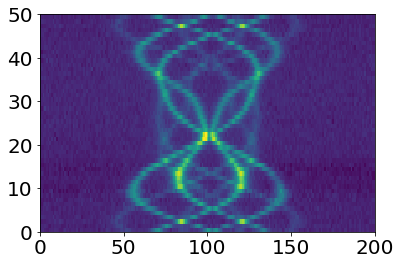

In [168]:
Xo = esr_preprocessing(np.expand_dims(esr_map, axis=0))
Xo = np.flip(Xo, axis=1)  # flip the image upside down

Xo = pad_image(Xo, img_dims)
plt.pcolor(Xo[0])
Xo[0].min(), Xo[0].max(), Xo[0].shape

In [169]:
from imageio import imsave
img = Xo[0]-Xo.min()
img = 255 * img / img.max()
img = img.astype(np.uint8)

# import scipy.misc

imsave('esr_map.jpg', img)

In [170]:
Xo = pad_image(Xo, (100,200))
Xo.shape

(1, 100, 200)

In [171]:
esr_y_pred = model.predict(np.expand_dims(Xo, axis=-1))
esr_y_pred

array([[0.09039631, 0.04346977, 0.43690073, 0.46156785, 0.5400817 ,
        0.05651256, 0.11132278]], dtype=float32)

In [172]:
y_scaler.labels = ['particle_radius',
 'nv_radius',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'xo',
 'yo']

In [173]:
esr_y_pred_real = y_scaler.inverse_transform(esr_y_pred, inplace=False)[0]

In [174]:
pd.DataFrame(np.expand_dims(esr_y_pred_real, axis=0), columns=labels_Y)

,particle_radius,nv_radius,theta_mag,phi_mag,dipole_height,xo,yo
0,17.423779,72.608185,39.321068,83.082214,57.4049,-1.609246,1.679367


In [175]:
# magnet_parameters={'particle_radius': [18, 4],
#  'nv_radius': 72.433,
#  'theta_mag': [45, 90],
#  'phi_mag': [45, 90],
#  'dipole_height': [70, 20],
#  'shot_noise': 0,
#  'linewidth': 14000000.0,
#  'n_angle': 45,
#  'n_freq': 200,
#  'f_min': 2670000000.0,
#  'f_max': 3068000000.0,
#  'avrg_count_rate': 1,
#  'xo': [0, 3],
#  'yo': [0, 3]}

In [176]:
# 


In [184]:
magnet_parameters_new = {**magnet_parameters, **{k:v for k, v in zip(labels_Y,esr_y_pred_real)}}
# if magnet_parameters_new contains ranges we take the first value which corresponds to the center of the range
# in the future we might provide an option to change this behaviour
magnet_parameters_new = {**magnet_parameters_new,
                         **{k: v[0] for k, v in magnet_parameters_new.items() if type(v) in (list, tuple)}}
magnet_parameters_new['Br']=1
magnet_parameters_new

{'particle_radius': 17.423779,
 'nv_radius': 72.608185,
 'theta_mag': 39.321068,
 'phi_mag': 83.082214,
 'dipole_height': 57.4049,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': -1.6092463,
 'yo': 1.6793666,
 'MW_rabi': 4,
 'Dgs': 2.87,
 'Br': 1}

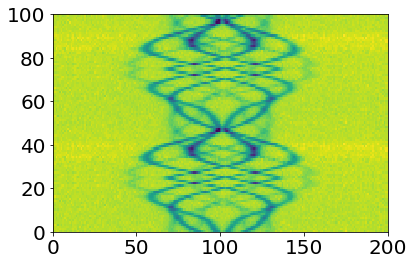

In [185]:
img_exp = np.squeeze(Xo[0])
img_exp -= img_exp.min()
img_exp /= img_exp.max()
img_exp = 1-img_exp

img_exp.min(), img_exp.max()

plt.pcolor(img_exp)

TypeError: Dimensions of C (100, 200) are incompatible with X (200) and/or Y (50); see help(pcolor)

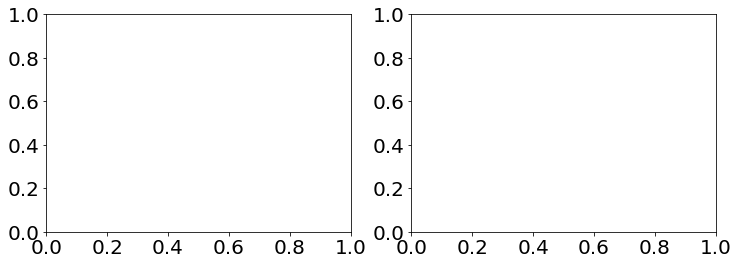

In [455]:
f_min = magnet_parameters['f_min']
f_max = magnet_parameters['f_max']
n_angle = magnet_parameters['n_angle']
n_freq = magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle+1)[0:-1]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# and create the image, construction in second argument constructs the updates parameter dictionary
img = create_image(**magnet_parameters_new)

Z, angle, frequencies = pad_image(img, img_dims, angles=angle, frequencies=frequencies)
img= Z / np.tile(Z.mean(axis=1), (Z.shape[1],1)).T
ax[0].pcolor(frequencies, angle, np.squeeze(Xo[0]))
ax[0].set_title('data')
ax[1].pcolor(frequencies, angle, img)
ax[1].set_title('reconstructed')
# ax[1].set_title(
#     'reconstructed\n' + ', '.join([label_map[k] + '={:0.2f}' for k in labels]).format(*esr_y_pred_real[0]))
plt.tight_layout()

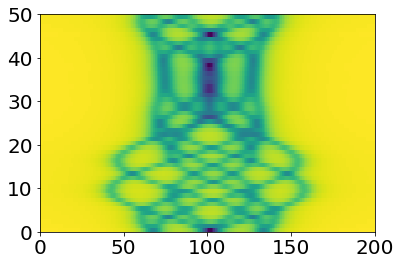

In [458]:
plt.pcolor(img)

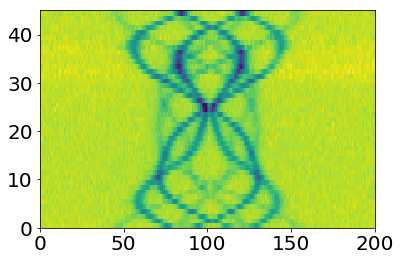

In [459]:
plt.pcolor(esr_map)

In [186]:
img = create_image(**{**magnet_parameters_new, 'use_Pl':True})

In [181]:
img_c = create_image(**{**magnet_parameters_new, 'use_Pl':False})

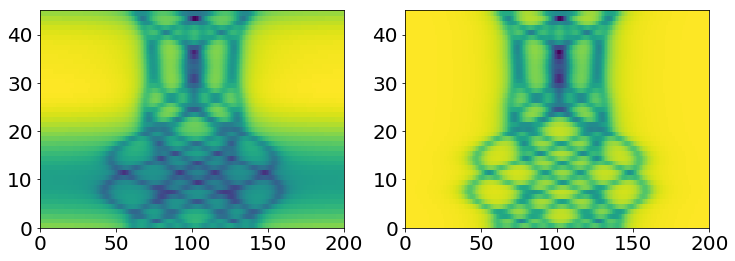

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].pcolor(img)
ax[1].pcolor(img_c)
# ax[0].pcolor()

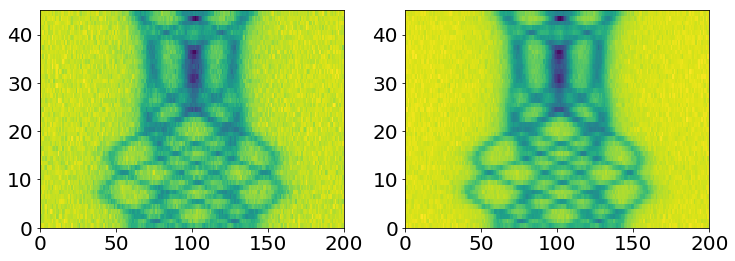

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Z = img/img.max() + 0.002*np.random.randn(*img.shape)
Z=Z / np.tile(Z.mean(axis=1), (Z.shape[1],1)).T
Z_c = img_c/img_c.max() + 0.002*np.random.randn(*img_c.shape)
Z_c=Z_c / np.tile(Z_c.mean(axis=1), (Z_c.shape[1],1)).T
ax[0].pcolor(Z)
ax[1].pcolor(Z_c)


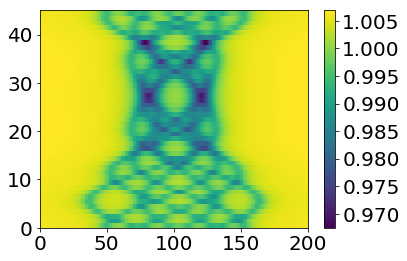

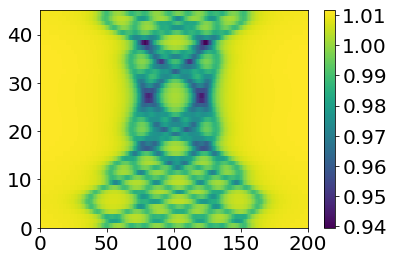

In [238]:
for Zo in [img, img_c]:

    Z=Zo / np.tile(Zo.mean(axis=1), (Zo.shape[1],1)).T
    plt.figure()
    plt.pcolor(Z)
    plt.colorbar()





In [257]:
img, esr = create_image(**magnet_parameters_new, return_esr_freqs=True)

(45, 4, 2)

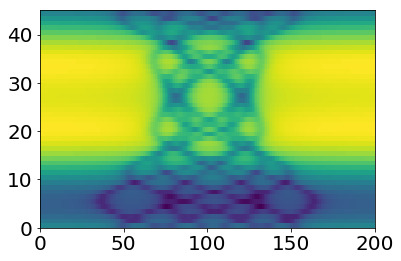

In [252]:
plt.pcolor(img)



In [261]:
esr.T.shape

(2, 4, 45)

(4, 45)
(4, 45)


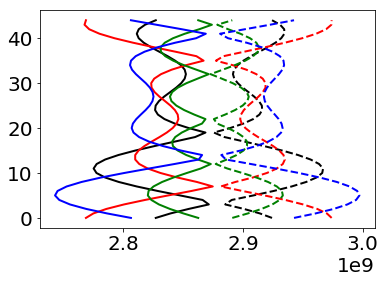

In [266]:
colors = 'krgb'
line_style = ['-', '--']

for esr_x, ls in zip(esr.T, line_style):
    for line, c in zip(esr_x, colors):
        plt.plot(line, range(len(line)), c+ls)
    print(esr_x.shape)

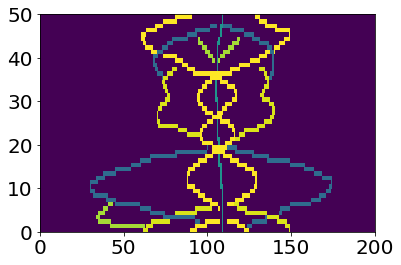

In [394]:
x.shape

(50, 200)

[ 90 133 221 241 255]


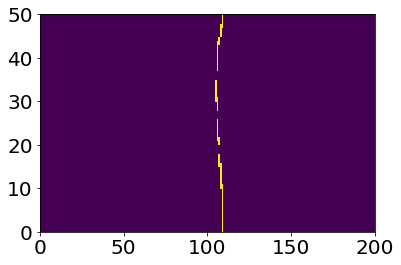

In [380]:
x = imarray[:,:,0]+imarray[:,:,1]*255+imarray[:,:,2]*2*255

lines_ids = np.unique(x)[1:]
print(lines_ids)

x[np.where(x!=133)]=0
plt.pcolor(x)

# plt.pcolor(x)
# # y = x.flatten()[idx].reshape(x.shape)
# print(x.shape)


In [352]:
line_id

16

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0,0.5,'|B| (mT)')

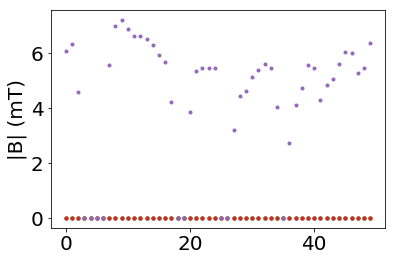

In [389]:
import pynvcenter.nv_optical_response as nv


Dgs = 2.87e9

for line_id in lines_ids:
    
    x = np.sum(imarray, axis=-1)
    x[np.where(x!=line_id)]=0
    field = np.zeros([len(x), 2])
    for i in range(len(x)):

        fo = frequencies[x[i]!=0]
        if len(fo)>=2:
            fm, fp = np.mean(fo[fo<Dgs]), np.mean(fo[fo>Dgs])
            bfield = nv.B_field_from_esr(fp, fm, D=Dgs, gamma=27.969e9, angular_freq=False, verbose=False)
            field[i] = bfield
    plt.plot(np.sqrt(np.sum(field**2, axis=1))*1e3, '.')
        
plt.ylabel('|B| (mT)')

In [393]:
len(angles), len(np.sqrt(np.sum(field**2, axis=1)))

(45, 50)

In [395]:
4*1e-3*27.969

0.111876

## simple approach, find the best overlap - not finished!

In [243]:
combine_data=False  ## if true concatenate all the dataset with the same name and only differing last three digits



filename = 'sim_data_2_--type--_000'
tag = filename.split('_--type')[0].split('/')[-1]
# filename = path_data/filename
filename

'sim_data_2_--type--_000'

In [244]:
with open(path_data/(filename.replace('--type--', 'parameters')+'.json'), 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

{'particle_radius': [16, 8],
 'nv_radius': 72.433,
 'theta_mag': [45, 90],
 'phi_mag': [45, 90],
 'dipole_height': [55, 60],
 'shot_noise': 0,
 'linewidth': 14000000.0,
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': [0, 3],
 'yo': [0, 3]}

In [46]:
with open(path_data/(filename.replace('--type--', 'labels') + '.txt'),"r") as filein:
    labels = filein.read().split(',')
labels

['particle_radius', 'theta_mag', 'phi_mag', 'dipole_height', 'xo', 'yo']

In [61]:
if combine_data:
    train_set = None
    for f in path_data.glob( ('*'+ '_'.join((filename.replace('--type--', 'train')+'.h5').split('_')[0:-1]) +'*')):
        print(f)
        hf = h5py.File(f, 'r')
        
        if train_set is None:
            train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
        else:
            train_set = {k: np.vstack([train_set[k], np.array(hf.get(k))]) for k in hf.keys()}
            
        hf.close()

else:
    f = path_data/(filename.replace('--type--', 'train')+'.h5')
    print(f)
    hf = h5py.File(f, 'r')
    train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
    hf.close()



# hf = h5py.File(path_data/(filename.replace('--type--', 'train')+'.h5'), 'r')
# train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
# hf.close()

../data/sim_data_2_train_000.h5


In [62]:
added_noise =  0.01
noise = added_noise*np.random.randn(*train_set['X'].shape)
X = train_set['X']+ noise
# X = esr_preprocessing(X, reference_level=1)  
# noise = added_noise*np.random.randn(*X.shape)
# X = X + noise
# X = esr_preprocessing(X, reference_level=1)

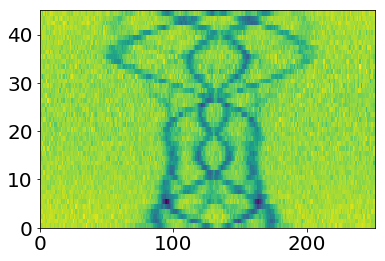

In [245]:
plt.pcolor(esr_map)

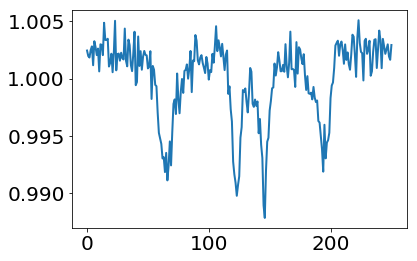

In [248]:
plt.plot(esr_map[38])

In [65]:
(X.max()-X.min())/added_noise

39.48767364146079

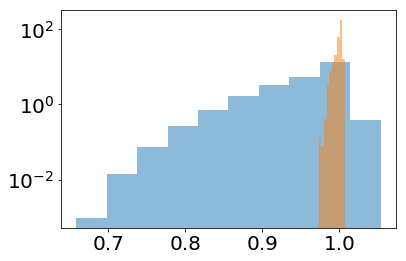

In [63]:
plt.hist(X.flatten(), log=True, density=True,alpha=0.5)
plt.hist(esr_map.flatten(), density=True, log=True,alpha=0.5);

In [130]:
added_noise = 0.005

X = train_set['X']
# noise = added_noise*np.random.randn(*X.shape)
# X = X + noise
X = 0.5+esr_preprocessing(X, reference_level='min_max')

In [131]:
X.shape,X.min(), X.max()

((10000, 45, 200), -0.002441, 1.002)

In [132]:
X_exp = 0.5+esr_preprocessing(np.expand_dims(esr_map[:,26:-25], 0), reference_level='min_max')

X_exp.shape, X_exp.min(), X_exp.max()

((1, 45, 200), 0.0, 1.0)

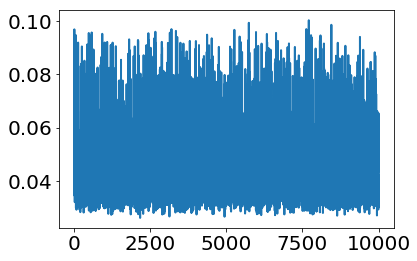

In [133]:
n= 10000
err = np.mean(np.reshape((np.repeat(X_exp,n, axis=0)-X[0:n])**2, (n, -1)), axis=1)

plt.plot(err)

In [134]:
err.argmin()

2167

In [135]:
esr_map[:,26:-25].max()

1.0062332152795714

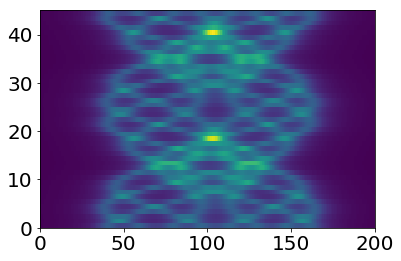

In [136]:
plt.pcolor(X[err.argmin()])

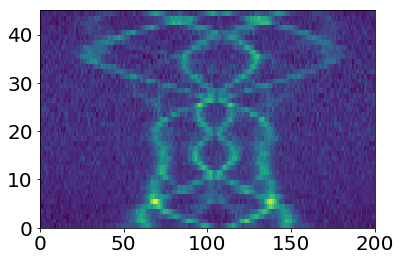

In [109]:
plt.pcolor(X_exp[0])

## testing the code - playing around

In [75]:
import pynvcenter.nv_optical_response as nv


# nv.esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)

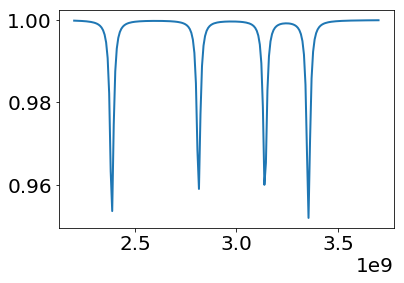

In [90]:
B_lab = np.expand_dims([0.01, 0.01,0.01], 0)
frequencies = np.linspace(2.2e9, 3.7e9, 201)
Dgs=2.87

avrg_count_rate = 1
linewidth = 10e6

contrast = nv.esr_contrast_ensemble(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1)#, Dgs=Dgs
esr_freq = nv.esr_frequencies_ensemble(B_lab)#, Dgs=Dgs

sig = nv.esr_odmr_signal_ensemble(
            frequencies,
            esr_freq.flatten(), contrast.flatten(),
            avrg_count_rate,
            linewidth=linewidth,
            shot_noise=0)
plt.plot(frequencies, sig)

In [83]:
contrast

array([[[2.96165563e-02, 2.36265430e-02],
        [2.96165563e-02, 2.36265430e-02],
        [2.96165563e-02, 2.36265430e-02],
        [2.37857200e+01, 2.37857200e+01]]])

In [84]:
nv.esr_contrast_ensemble(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1)#, Dgs=Dgs

array([[[6.06130487e+09, 1.01781124e+10],
        [6.06130487e+09, 1.01781124e+10],
        [6.06130487e+09, 1.01781124e+10],
        [1.97437290e+09, 9.68874581e+09]]])

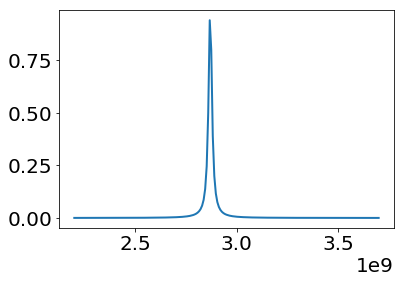

In [94]:
def lorenz(w, wo=2*np.pi*2.87e9, linewidth= 2*np.pi*10e6):
    return linewidth**2 / ( (w-wo)**2+linewidth**2 )

w = 2*np.pi*frequencies

plt.plot(frequencies, lorenz(w))

In [95]:
C = []
for i in range(4):
    # get the off axis and on axis field for NV_i
    BNV = B_fields_in_NV_frame(B_lab,i)
    
    Cm = photoluminescence_contrast(BNV, k12=k_MW, k13=0, beta=beta)
    C.append(Cm)

1.0

In [ ]:
def esr_contrast_ensemble_2(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1, Dgs=2.87):
    """
    calculates the esr contrast for the four NV families for a given magnetic field in the lab frame

    B_lab: magnetic field in the lab frame (N x 3) matrix
    k_MW: is the Rabi frequency applied to the ESR transition

    returns the esr contrast for all 4 NV families as M x N array, where
        M is the number of magnetic fields
        N = 4 is the number of NV families
    """

    C = []
    # get b field in cartesian coordinates

    for i in range(4):
        # get the off axis and on axis field for NV_i
        BNV = B_fields_in_NV_frame(B_lab,i)
        # calculate the ESR freq. for NV_i
        # we just calculate the maximum contrast for each of the two transitsion and sum them up
        # to get the spectrum, we just assume two Lorenzians
        # An alternative approach would be to assume that the MW freqs. follow a Lorenzian and calculate the photoluminescence contrast for each MW freq.
        Cm = photoluminescence_contrast(BNV, k12=k_MW, k13=0, beta=beta)
        Cp = photoluminescence_contrast(BNV, k12=0, k13=k_MW, beta=beta)

        C.append(np.vstack([Cm, Cp]).T)

    # rearrange so that we return a M x N x 2 array
    # M is the number of magnetic fields
    # N is the number of NV families
    return np.moveaxis(C, 0, 1)

# Fitting to dipole - line data

In [461]:
lines = pd.DataFrame.from_csv(filename_esr+'_line_data.csv')
Dgs =2.86 # 2.87

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [462]:
# # angles = np.linspace(0, 360, esr_map.shape[0])
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# angle = np.linspace(0,360,esr_map.shape[0]+1)[0:-1]
# ax.pcolor(frequencies*1e-9, angle, esr_map)

# # # Create a Rectangle patch
# # rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
# #                  noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# # # Add the patch to the Axes
# # ax.add_patch(rect)

# ax.set_ylabel('angle (deg)')
# ax.set_xlabel('freq (Hz)')
# # ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
# plt.tight_layout()

# for line in lines.values.T:
#     plt.plot(line*1e-9, angle)
# plt.xlim([min(frequencies*1e-9), max(frequencies*1e-9)])
# plt.ylim([min(angle), max(angle)])

# plt.plot([Dgs, Dgs], [0,360], 'k-')
# # fig.savefig('171222_esr_map.png')

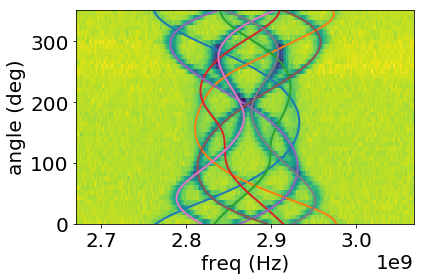

In [464]:

plot_line_on_map(angles, frequencies, esr_map, lines.values)

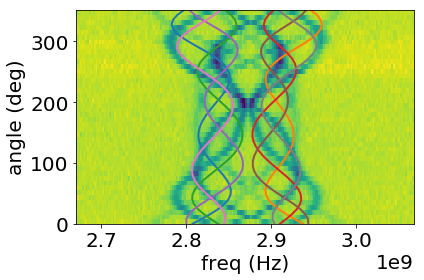

In [465]:
esr_pred = esr_ring_scan_freqs(angles+t_r, **fit_result)

plot_line_on_map(angles, frequencies, esr_map, esr_pred)

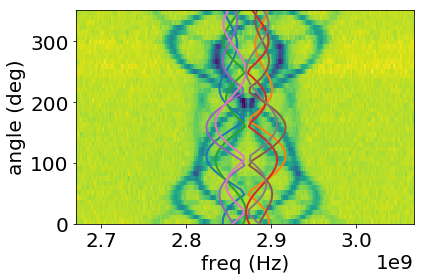

In [476]:
initial_guess = {
    'particle_radius': 1.4,
    'nv_radius': 5.18,
    'nv_x': 0,
    'nv_y': 0,
    'theta_mag': 90,
    'phi_mag': -20,
    'dipole_height': 1.4, 
    'Br':0.32,
    'phi_r' : 5
}


initial_guess = {
    'particle_radius': 19,
    'nv_radius': 70,
    'nv_x': 0,
    'nv_y': 0,
    'theta_mag': -45,
    'phi_mag': 0,
    'dipole_height': 30, 
    'Br':0.2,
    'phi_r' : 0
}

t_r = 45
esr_pred = esr_ring_scan_freqs(angles+t_r, **initial_guess)

plot_line_on_map(angles, frequencies, esr_map, esr_pred)

# t_r=10
# for line in lines.values.T:
#     plt.plot(line*1e-9, angle, '.')

# # angle_shifted = (t_r+angle)%360
# esr_pred = esr_ring_scan_freqs(angle+t_r, **initial_guess)[:,:,0]*1e-9
# # for d in esr_pred[angle_shifted.argsort()].T:
# for d in esr_pred.T:
#     plt.plot(d,angle, 'k--')
    

In [49]:
particle_radius = initial_guess['particle_radius']
Br = initial_guess['Br']
mu0 = 4 * np.pi * 1e-7  # T m /A
dipole_strength = 4 * np.pi / 3 * (particle_radius) ** 3 / mu0*Br
dipole_strength /2605708.2884352305

2807.784240138485

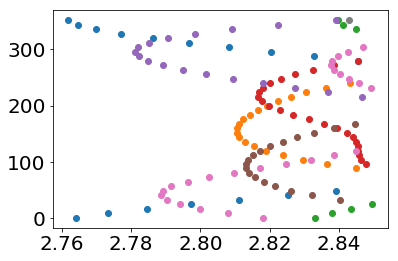

In [50]:
angles = []
data = []

# for l in lines_ids[[0, 1]]:
for l in lines.values.T:
    angles.append(angle[l*1e-9<Dgs-0.01])
    data.append(l[l*1e-9<Dgs-0.01]*1e-9)
    plt.plot(data[-1],angles[-1], 'o')

17 17
20 20
7 7
24 24


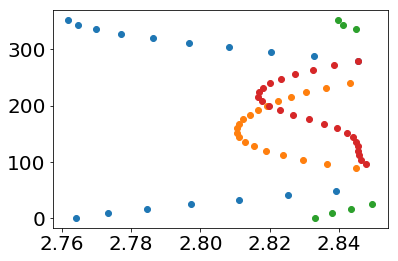

In [51]:
for l, a in zip(data[0:4], angles[0:4]):
    print(len(l), len(a))
    plt.plot(l, a, 'o')

In [52]:
len(angles)

8

## perform fit

In [53]:
# initial_guess = {'particle_radius': (17, 5),
#  'nv_radius': (72, 5),
#  'nv_x': (0, 40),
#  'nv_y': (0, 20),
#  'theta_mag': (0, 60),
#  'phi_mag': (0, 60),
#  'dipole_height': (30, 30)}

# initial_guess = {'particle_radius': 1.4,
#  'nv_radius': 3.4,
#  'nv_x': (0, 10),
#  'nv_y': (0, 10),
#  'theta_mag': 0,
#  'phi_mag': 0,
#  'dipole_height': (3, 6)}


fit_parameter_keys=[k for k in initial_guess.keys() if k not in ['nv_radius', 'particle_radius', 'nv_x', 'nv_y', 'dipole_height']]
# fit_parameter_keys=initial_guess.keys()

from itertools import combinations, permutations
df = None
# starting_angles = list(range(0,360,20))
starting_angles = [0,45]
for to, po in tqdm(list(permutations(starting_angles, 2))):
#     print('------ ', to, po, ' -------')
    initial_guess_2 = {**initial_guess, 'theta_mag':to, 'phi_mag':po}

    fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess_2, transition=0, verbose=False,
                     fit_parameter_keys=fit_parameter_keys, data_from_different_nvs=False)
    
    
    df_dict = {'loss':result.fun,'sucess':result.success, **{k:[v] for k, v in fit_result.items()}}
    if df is None:
        df = pd.DataFrame.from_dict(df_dict)
    else:
        df = df.append(pd.DataFrame.from_dict(df_dict))
#     print(result.fun, fit_result)
df = df.reset_index()

100%|██████████| 2/2 [00:32<00:00, 16.24s/it]


In [66]:
for d in data:
    print(d.shape)

(17,)
(20,)
(7,)
(24,)
(18,)
(18,)
(26,)
(1,)


In [240]:
x = [[2.76405982e+09, 2.67649018e+09],
       [2.81797168e+09, 2.92456125e+09],
       [2.83326786e+09, 2.61379401e+09],
       [2.86285388e+09, 2.89536875e+09]]

?np.sort(x)

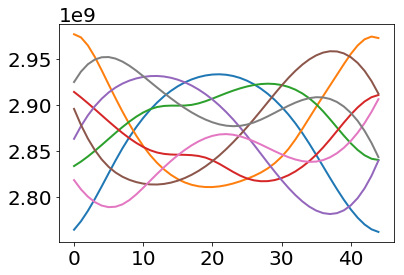

In [283]:
for l in lines.values.T:
    plt.plot(l)

In [350]:
from scipy.optimize import minimize
data = sort_freq_pairs(lines.values)*1e-9
fit_parameter_keys = ['theta_mag', 'phi_mag', 'dipole_height', 'Br', 'phi_r']
fit_result, result = fit_continuous_esr_lines(angles, data, initial_guess, verbose=False, fit_parameter_keys=None)

In [349]:
initial_guess.keys()

dict_keys(['particle_radius', 'nv_radius', 'nv_x', 'nv_y', 'theta_mag', 'phi_mag', 'dipole_height', 'Br', 'phi_r'])

0.09220379219544568

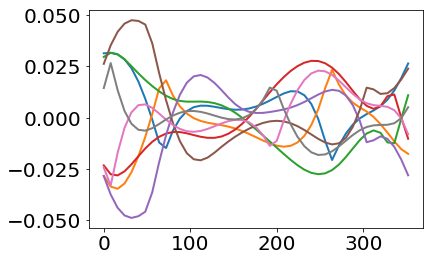

In [351]:

loss_continous_lines(fit_result, angles, data, plot_difference=True)

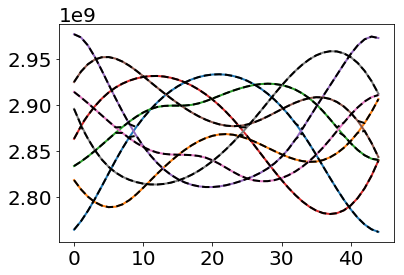

In [284]:
for x in concat_freq_pairs(X).T:
    plt.plot(x[0:45])

for x in concat_freq_pairs(X).T:
    plt.plot(x[45:])
    
for l in sort_freq_pairs(lines.values).reshape(-1,8).T:
    plt.plot(l, 'k--')



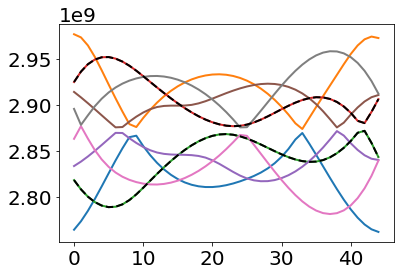

In [296]:
for l in sort_freq_pairs(lines.values).reshape(-1,8).T:
    plt.plot(l)
    
XX = sort_freq_pairs(lines.values).reshape(-1,8).T
# plt.plot(XX[0], 'k--')
# plt.plot(XX[1], 'k--')

plt.plot(XX[2], 'k--')
plt.plot(XX[3], 'k--')

# plt.plot(XX[4], 'k--')
# plt.plot(XX[5], 'k--')

# plt.plot(XX[6], 'k--')
# plt.plot(XX[7], 'k--')

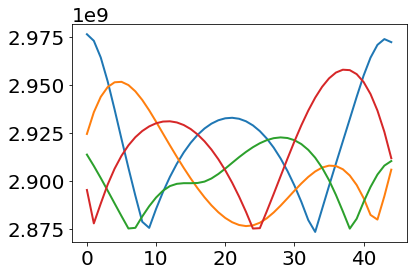

In [304]:
for l in sort_freq_pairs(lines.values)[:,:,1].T:
    plt.plot(l)

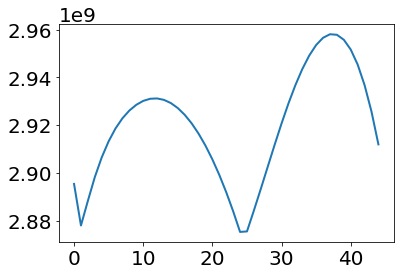

In [305]:
plt.plot(l)

In [244]:
for l in 
    plt.plot(l)

(45, 4, 2)

In [83]:
from pynvcenter.nv_optical_response import esr_connect

In [90]:
l, len(angle), X.shape

(array([2.85493534e+09, 2.89357633e+09, 2.80844163e+09, 2.93619933e+09,
        2.84183021e+09, 2.90599667e+09, 2.79470730e+09, 2.94805503e+09]),
 45,
 (45, 8))

(45, 4, 2)


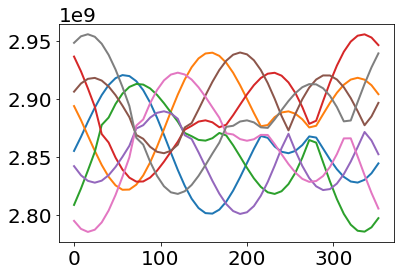

In [91]:
X = esr_ring_scan_freqs(angle, **initial_guess)
print(X.shape)
X = esr_connect(X).reshape(-1,8)

for l in X.T:
    plt.plot(angle, l)

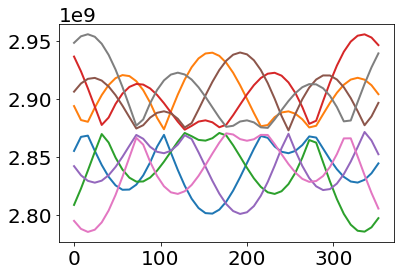

In [63]:
for l in esr_ring_scan_freqs(angle, **initial_guess).reshape(-1,8).T:
    plt.plot(angle, l)

In [54]:
best_fit_params = df[df.loss==df.min().loss][list(initial_guess.keys())].to_dict('records')[0]
print('min loss', df.min().loss)
pd.DataFrame.from_dict({k:[v] for k, v in best_fit_params.items()})

min loss 0.04838063465880901


,particle_radius,nv_radius,nv_x,nv_y,theta_mag,phi_mag,dipole_height,Br,phi_r
0,19.0,70.0,0.0,0.0,9.12335,0.768452,30.0,0.403949,-5.451244


In [55]:
def highlight(s):
#     print(s)
    if s.loss <= df.min().loss:
        return ['background-color: yellow']*df.shape[1]
    else:
        return ['background-color: white']*df.shape[1]
df.style.apply(highlight, axis=1)

,index,loss,sucess,theta_mag,phi_mag,Br,phi_r,particle_radius,nv_radius,nv_x,nv_y,dipole_height
0,0,0.0483806,True,9.12335,0.768452,0.403949,-5.45124,19,70,0,0,30
1,0,0.0492407,True,37.0609,8.09552,0.546682,-19.2219,19,70,0,0,30


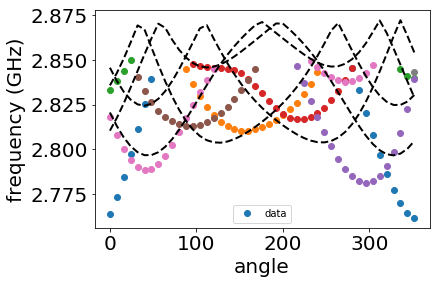

In [56]:

# initial_guess = {
#     'particle_radius':(17,5),
#     'nv_radius':(70,5),
#     'nv_x':(0,5),
#     'nv_y':(0,5),
#     'theta_mag':(120,45),
#     'phi_mag':(125,180),
#     'dipole_height':(50,30)
# }
# print('------=======------')
# # result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True)
# fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True,
#                  fit_parameter_keys=fit_parameter_keys)
# # figure out if we recieved just a single set or several datasets
# is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False



# for i, (d, a) in enumerate(zip(data, angles)):
#     y = np.tile(d,4).reshape(-1, len(d)).T

#     label='data' if i==0 else None 
#     plt.plot(a, d, 'o', label=label)

#     label='fit' if i==0 else None
    
    
#     y_pred = esr_ring_scan_freqs(a, *result.x)[:,:,transition]*1e-9
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     plt.plot(a, y_pred[:,idx], 'b-', label=label)
    
#     param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     label='initial' if i==0 else None
#     plt.plot(a, y_pred[:,idx], 'g--', label=label)
    
colors = []



for i, (d, a) in enumerate(zip(data, angles)):
    label='data' if i==0 else None
    p = plt.plot(a, d, 'o', label=label)
    colors.append(p[0].get_color())

# err, freqs, ids = loss_arcs(best_fit_params, angles, data, transition=0)
# for i, (f, a, c) in enumerate(zip(freqs, angles, colors)):
#     label='fit' if i==0 else None
#     p = plt.plot(a, f, c, label=label)
    
# err, freqs_0, ids = loss_arcs({k:v for k, v in zip(initial_guess.keys(), param_init)}, angles, data, transition=0)
# for i, (f, a) in enumerate(zip(freqs_0, angles)):
#     label='initial' if i==0 else None
#     p = plt.plot(a, f, 'k--', label=label)
    
    
    
plt.legend()
plt.xlabel('angle')
plt.ylabel('frequency (GHz)')



# esr_pred = esr_ring_scan_freqs(angle, *result.x)[:,:,0]*1e-9
# for d in esr_pred.T:
#     plt.plot(angle, d, 'k--')

esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(angle, d, 'k--')
    

## just a fit

In [544]:
fit_parameter_keys=[k for k in initial_guess.keys() if
#                     k not in ['nv_radius', 'particle_radius', 'nv_x', 'nv_y']]
#                     k not in []]
#                     k not in ['nv_radius', 'particle_radius', 'nv_x', 'nv_y', 'dipole_height']]
#                     k not in ['nv_radius', 'particle_radius', 'dipole_height','theta_mag','phi_mag']]
                    k not in ['nv_radius', 'particle_radius']]
initial_guess = {
    'particle_radius': (1.4, 0.2),
    'nv_radius': 5.18,
    'nv_x': 0,
    'nv_y': 0,
    'theta_mag': (90, 90),
    'phi_mag': (0,90),
    'dipole_height': 1.4, 
    'Br':(0.32, 0.05),
    'phi_r' : (-25,90)
}



fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=False,
                 fit_parameter_keys=fit_parameter_keys, data_from_different_nvs=False)


df_dict = {'loss':result.fun,'sucess':result.success, **{k:[v] for k, v in fit_result.items()}}

df = pd.DataFrame.from_dict(df_dict)
df

,loss,sucess,nv_x,nv_y,theta_mag,phi_mag,dipole_height,Br,phi_r,particle_radius,nv_radius
0,0.024242,True,0.009236,-0.012777,110.134678,-5.631189,0.548345,0.309713,-32.528639,1.4,5.18


In [549]:
# colors = []



# for i, (d, a) in enumerate(zip(data, angles)):
#     label='data' if i==0 else None
#     p = plt.plot(a, d, 'o', label=label)
#     colors.append(p[0].get_color())

# err, freqs, ids = loss_arcs(fit_result, angles, data, transition=0)
# for i, (f, a, c) in enumerate(zip(freqs, angles, colors)):
#     label='fit' if i==0 else None
#     p = plt.plot(a, f, c, label=label)
    
    
# plt.legend()
# plt.xlabel('angle')
# plt.ylabel('frequency (GHz)')

# # esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
# # for d in zip(esr_pred.T, colors):
# #     plt.plot(angle, d[0], c)
    

In [550]:
conected_freqs = [[], [], [], []]
conected_angles = [[], [], [], []]
for f, i, a in zip(freqs, ids, angles):
    conected_freqs[i] = np.hstack([conected_freqs[i], f])
    conected_angles[i] = np.hstack([conected_angles[i], a])


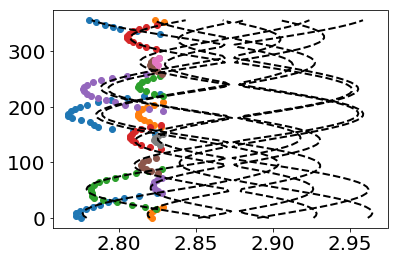

In [551]:
for i, (d, a) in enumerate(zip(data, angles)):
    label='data' if i==0 else None
    p = plt.plot(d, a,'o', label=label)
    colors.append(p[0].get_color())
    
esr_pred = esr_ring_scan_freqs(angle, **fit_result)*1e-9
for d in esr_pred.reshape(-1,8).T:
    plt.plot(d,angle,  'k--')
# for a, f in zip(conected_angles, conected_freqs):
# #     print(len(a), len(f))
#     plt.plot(a, f)

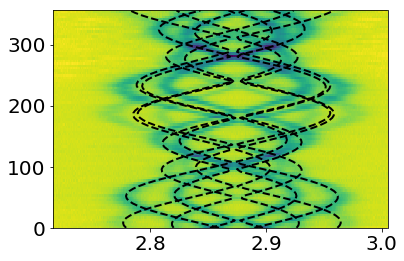

In [548]:
plt.pcolor(frequencies*1e-9, angle, esr_map)

    
esr_pred = esr_ring_scan_freqs(angle, **fit_result)*1e-9
for d in esr_pred.reshape(-1,8).T:
    plt.plot(d,angle,  'k--')

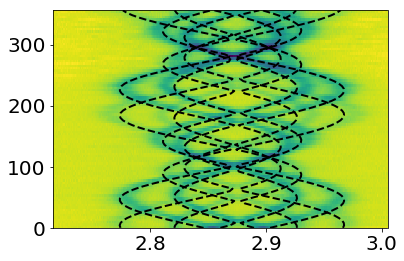

In [543]:
initial_guess = {
    'particle_radius': (1.4, 0.2),
    'nv_radius': 5.18,
    'nv_x': 0.,
    'nv_y': 0,
    'theta_mag': (90, 90),
    'phi_mag': (0,90),
    'dipole_height': 1.4, 
    'Br':(0.33, 0.05),
    'phi_r' : (-25,90)
}



initial_guess_2 = {k:v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()}

plt.pcolor(frequencies*1e-9, angle, esr_map)

    
esr_pred = esr_ring_scan_freqs(angle, **initial_guess_2)*1e-9
for d in esr_pred.reshape(-1,8).T:
    plt.plot(d,angle,  'k--')

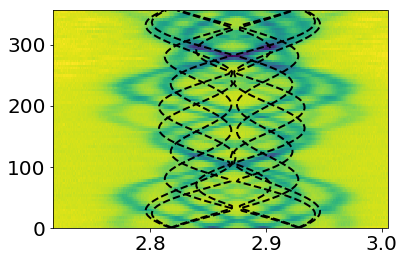

# get magnet parameters from magnetic fields

In [429]:
esr_data = sort_freq_pairs(lines.values)

In [445]:
import pynvcenter.nv_optical_response as nv
from pynvcenter.fit_magnetic_dipole import *




/Users/rettentulla/PycharmProjects/pynvcenter/pynvcenter/nv_optical_response.py:672: RuntimeWarning: invalid value encountered in sqrt
  Bz = np.sqrt(-(D + wp - 2 * wn) * (D + wn - 2 * wp) * (D + wn + wp)) / (3 * gamma * np.sqrt(3 * D))
/Users/rettentulla/PycharmProjects/pynvcenter/pynvcenter/nv_optical_response.py:673: RuntimeWarning: invalid value encountered in sqrt
  Bp = np.sqrt(-(2 * D - wp - wn) * (2 * D + 2 * wn - wp) * (2 * D - wn + 2 * wp)) / (3 * gamma * np.sqrt(3 * D))


/Users/rettentulla/PycharmProjects/pynvcenter/pynvcenter/nv_optical_response.py:672: RuntimeWarning: invalid value encountered in sqrt
  Bz = np.sqrt(-(D + wp - 2 * wn) * (D + wn - 2 * wp) * (D + wn + wp)) / (3 * gamma * np.sqrt(3 * D))
/Users/rettentulla/PycharmProjects/pynvcenter/pynvcenter/nv_optical_response.py:673: RuntimeWarning: invalid value encountered in sqrt
  Bp = np.sqrt(-(2 * D - wp - wn) * (2 * D + 2 * wn - wp) * (2 * D - wn + 2 * wp)) / (3 * gamma * np.sqrt(3 * D))


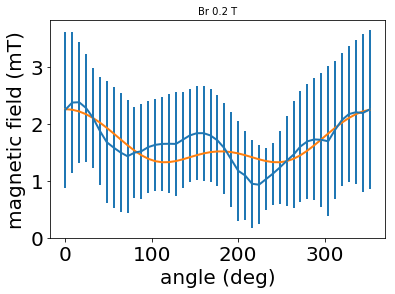

In [451]:
B = np.array([nv.B_field_from_esr_ensemble(d) for d in esr_data]).reshape(-1,8)
sB = np.std(B, axis=1)
B = np.mean(B, axis=1)

magnet_diam = 2*19
radius = 70
mag_moment, Br, par, perr, init_guess = fit_ring(B, angles/180*np.pi, sB, magnet_diam, radius, fix_theta_mag=False)

plt.errorbar(angles, 1e3*B, yerr=1e3*sB)
plt.xlabel('angle (deg)')
plt.ylabel('magnetic field (mT)')
plt.title('Br {:0.2} T'.format(Br))

plt.plot(angles, 1e3*fit_err_fun_ring(angles/180*np.pi, *par))


In [452]:
par

array([1.32463890e-03, 6.24556999e-01, 1.27449956e+00, 8.81716617e-24])

In [450]:
par

array([1.29108597e-03, 7.24092324e-01, 1.27151859e+00, 5.89121864e-27])

# fitting to dipole

In [453]:
from PIL import Image


# im = Image.open('outfile_string.tif')
im = Image.open('outfile_1.tif')

imarray = np.array(im)[:,:,0] #, dtype=np.float16
imarray = np.flip(imarray, axis=1)
np.unique(imarray)

transition=0
angle = np.linspace(0, 360, np.shape(imarray)[0]+1)[0:-1]

In [454]:
lines_ids = np.unique(imarray)[0:-1]
len(lines_ids)

6

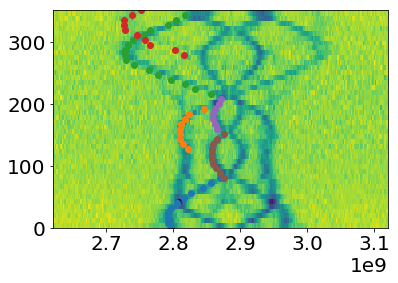

In [449]:
plt.pcolor(frequencies, angle, esr_map)
for l in lines_ids:
    x = np.array(im)[:,:,0] #, dtype=np.float16
#     x = np.flip(x, axis=1)
    x[np.where(x!=l)]=0
    line = [(angle[i],frequencies[list(row).index(max(row))]) for i, row in enumerate(x) if max(row)>0]
    line = np.array(line)
    plt.plot(line[:,1], line[:,0], 'o')
    
#     plt.figure()
    
#     plt.pcolor(x)

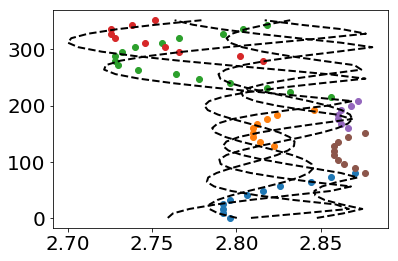

In [450]:
angles = []
data = []

# for l in lines_ids[[0, 1]]:
for l in lines_ids:
    x = np.array(im)[:,:,0] #, dtype=np.float16
    x[np.where(x!=l)]=0
    line = [(angle[i],1e-9*frequencies[list(row).index(max(row))]) for i, row in enumerate(x) if max(row)>0]
    line = np.array(line)
    
    angles.append(line[:,0])
    data.append(line[:,1])
    plt.plot(data[-1], angles[-1], 'o')
    
    
    
initial_guess = {
    'particle_radius': (22,5),
    'nv_radius': 72,
    'nv_x': (0, 10),
    'nv_y': (0, 10),
    'theta_mag': 53,
    'phi_mag': 22,
    'dipole_height': (40, 30),
    'phi_r':(80, 45), 
    'Br':(0.5, 0.4)
}



esr_pred = esr_ring_scan_freqs(angle, **{k:v for k, v in zip(initial_guess.keys(), [v[0] if type(v) in (tuple, list) else v for v in initial_guess.values()])})[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(d, angle, 'k--')

In [451]:
fit_parameter_keys

['particle_radius',
 'nv_x',
 'nv_y',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'phi_r',
 'Br']

is single: False
param_init [22, 0, 0, 53, 22, 40, 80, 0.5]
bounds [(19.5, 24.5), (-5.0, 5.0), (-5.0, 5.0), (None, None), (None, None), (25.0, 55.0), (57.5, 102.5), (0.3, 0.7)]
fixed_parameters {'nv_radius': 72}


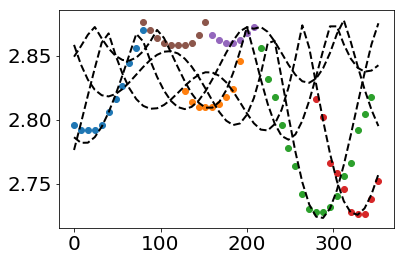

In [452]:

fit_parameter_keys=[k for k in initial_guess.keys() if k not in
#                     ['nv_radius', 'nv_x', 'nv_y', 'dipole_height', 'theta_max']
                    ['nv_radius']
                   ]

# result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True)
fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True,
                 fit_parameter_keys=fit_parameter_keys, data_from_different_nvs=False)
# figure out if we recieved just a single set or several datasets
is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False



for i, (d, a) in enumerate(zip(data, angles)):
#     y = np.tile(d,4).reshape(-1, len(d)).T

    label='data' if i==0 else None 
    plt.plot(a, d, 'o', label=label)

    label='fit' if i==0 else None
    
    
#     y_pred = esr_ring_scan_freqs(a, **fit_result)[:,:,transition]*1e-9
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     plt.plot(a, y_pred[:,idx], 'b-', label=label)
    
#     param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     label='initial' if i==0 else None
#     plt.plot(a, y_pred[:,idx], 'g--', label=label)

    
esr_pred = esr_ring_scan_freqs(angle, **fit_result)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(angle, d, 'k--')
    
colors = []


In [455]:
fit_result

{'particle_radius': 21.966355812453486,
 'nv_x': -3.987905899690726,
 'nv_y': 5.0,
 'theta_mag': 61.137339689307154,
 'phi_mag': 20.28470009980989,
 'dipole_height': 50.55873902955041,
 'phi_r': 57.5,
 'Br': 0.493344039584495,
 'nv_radius': 72}

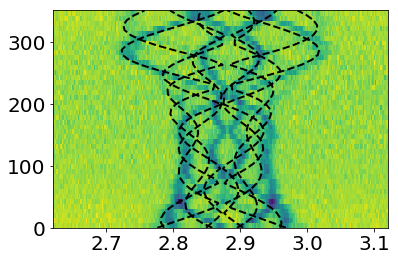

In [456]:
plt.pcolor(frequencies*1e-9, angle, esr_map)

    
esr_pred = esr_ring_scan_freqs(angle, **fit_result)*1e-9
for d in esr_pred.reshape(-1,8).T:
    plt.plot(d,angle,  'k--')

In [444]:
initial_guess

{'particle_radius': (22, 5),
 'nv_radius': 72,
 'nv_x': (0, 10),
 'nv_y': (0, 10),
 'theta_mag': 53,
 'phi_mag': 22,
 'dipole_height': (40, 30),
 'phi_r': (80, 45),
 'Br': (0.5, 0.4)}

In [445]:
param_init

[22, 0, 0, 53, 22, 40, 80, 0.5]

In [457]:

param_init = [v[0] if type(v) in (tuple, list) else v for v in [initial_guess[k] for k in fit_parameter_keys]]
df =pd.DataFrame.from_dict({
    'parameter set': ['initial guess', 'fit'],
    **{k:[v1,v2] for k, v1, v2 in zip(fit_parameter_keys, param_init ,fit_result.values())}
})
df

,parameter set,particle_radius,nv_x,nv_y,theta_mag,phi_mag,dipole_height,phi_r,Br
0,initial guess,22.000000,0.000000,0.0,53.00000,22.0000,40.000000,80.0,0.500000
1,fit,21.966356,-3.987906,5.0,61.13734,20.2847,50.558739,57.5,0.493344


In [150]:
for i, (d, a) in enumerate(zip(data, angles)):
#     y = np.tile(d,4).reshape(-1, len(d)).T

    label='data' if i==0 else None 
    plt.plot(a, d, 'o', label=label)

    label='fit' if i==0 else None
    
    
#     y_pred = esr_ring_scan_freqs(a, **fit_result)[:,:,transition]*1e-9
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     plt.plot(a, y_pred[:,idx], 'b-', label=label)
    
#     param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     label='initial' if i==0 else None
#     plt.plot(a, y_pred[:,idx], 'g--', label=label)

    
esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(angle, d, 'k--')

array([[2.86999965, 2.86999993, 2.86999966, 2.86999994],
       [2.86999965, 2.86999993, 2.86999965, 2.86999993],
       [2.86999966, 2.86999994, 2.86999965, 2.86999993],
       [2.86999966, 2.86999995, 2.86999964, 2.86999992],
       [2.86999967, 2.86999995, 2.86999963, 2.86999992],
       [2.86999967, 2.86999996, 2.86999962, 2.86999991],
       [2.86999967, 2.86999996, 2.86999961, 2.8699999 ],
       [2.86999967, 2.86999996, 2.8699996 , 2.86999989],
       [2.86999967, 2.86999997, 2.86999959, 2.86999988],
       [2.86999967, 2.86999997, 2.86999957, 2.86999987],
       [2.86999967, 2.86999998, 2.86999955, 2.86999986],
       [2.86999967, 2.86999998, 2.86999953, 2.86999984],
       [2.86999967, 2.86999999, 2.86999951, 2.86999983],
       [2.86999967, 2.86999999, 2.86999949, 2.86999981],
       [2.86999967, 2.87      , 2.86999946, 2.86999979],
       [2.86999966, 2.87      , 2.86999943, 2.86999977],
       [2.86999966, 2.86999999, 2.8699994 , 2.86999974],
       [2.86999966, 2.86999999,

In [144]:
# param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
# loss_arcs( {k: v for k, v in zip(initial_guess.keys(), param_init)}, angles, data, transition=0)

In [411]:

param_init = [v[0] if type(v) in (tuple, list) else v for v in initial_guess.values()]
df =pd.DataFrame.from_dict({
    'parameter set': ['initial guess', 'fit'],
    **{k:[v1,v2] for k, v1, v2 in zip(initial_guess.keys(), param_init ,result.x)}
})
df

,parameter set,particle_radius,nv_radius,nv_x,nv_y,theta_mag,phi_mag,dipole_height,phi_r
0,initial guess,22.000000,72.000000,0.0,0.000000,53.000000,22.000000,30.0,80.000000
1,fit,21.334075,-0.483049,5.0,61.914366,19.660782,52.109816,57.5,0.604647


In [390]:
fit_parameter_keys=[k for k in initial_guess.keys() if k not in ['nv_radius', 'nv_x', 'nv_y']]
fit_parameter_keys=[k for k in initial_guess.keys() if k not in ['nv_radius']]
fit_parameter_keys

['particle_radius', 'nv_x', 'nv_y', 'theta_mag', 'phi_mag', 'dipole_height']

In [ ]:

# initial_guess = {
#     'particle_radius':(17,5),
#     'nv_radius':(70,5),
#     'nv_x':(0,5),
#     'nv_y':(0,5),
#     'theta_mag':(120,45),
#     'phi_mag':(125,180),
#     'dipole_height':(50,30)
# }
# print('------=======------')
# # result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True)
# fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True,
#                  fit_parameter_keys=fit_parameter_keys)
# # figure out if we recieved just a single set or several datasets
# is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False



# for i, (d, a) in enumerate(zip(data, angles)):
#     y = np.tile(d,4).reshape(-1, len(d)).T

#     label='data' if i==0 else None 
#     plt.plot(a, d, 'o', label=label)

#     label='fit' if i==0 else None
    
    
#     y_pred = esr_ring_scan_freqs(a, *result.x)[:,:,transition]*1e-9
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     plt.plot(a, y_pred[:,idx], 'b-', label=label)
    
#     param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     label='initial' if i==0 else None
#     plt.plot(a, y_pred[:,idx], 'g--', label=label)
    
# colors = []



for i, (d, a) in enumerate(zip(data, angles)):
    label='data' if i==0 else None
    p = plt.plot(a, d, 'o', label=label)
    colors.append(p[0].get_color())

err, freqs, ids = loss_arcs(best_fit_params, angles, data, transition=0)
for i, (f, a, c) in enumerate(zip(freqs, angles, colors)):
    label='fit' if i==0 else None
    p = plt.plot(a, f, c, label=label)
    
# err, freqs_0, ids = loss_arcs({k:v for k, v in zip(initial_guess.keys(), param_init)}, angles, data, transition=0)
# for i, (f, a) in enumerate(zip(freqs_0, angles)):
#     label='initial' if i==0 else None
#     p = plt.plot(a, f, 'k--', label=label)
    
    
    
plt.legend()
plt.xlabel('angle')
plt.ylabel('frequency (GHz)')



# esr_pred = esr_ring_scan_freqs(angle, *result.x)[:,:,0]*1e-9
# for d in esr_pred.T:
#     plt.plot(angle, d, 'k--')

esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(angle, d, 'k--')
    

### limit the angle range and do a grid search, to find the global minimum 

In [391]:
initial_guess = {'particle_radius': (17, 5),
 'nv_radius': (72, 5),
 'nv_x': (0, 40),
 'nv_y': (0, 20),
 'theta_mag': (0, 60),
 'phi_mag': (0, 60),
 'dipole_height': (30, 30)}

initial_guess = {'particle_radius': 17,
 'nv_radius': 72,
 'nv_x': (0, 10),
 'nv_y': (0, 10),
 'theta_mag': 0,
 'phi_mag': 0,
 'dipole_height': (50, 100)}


from itertools import combinations, permutations
df = None
for to, po in tqdm(list(permutations(list(range(0,360,20)), 2))):
#     print('------ ', to, po, ' -------')
    initial_guess_2 = {**initial_guess, 'theta_mag':to, 'phi_mag':po}

    fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess_2, transition=0, verbose=False,
                     fit_parameter_keys=fit_parameter_keys, data_from_different_nvs=True)
    
    
    df_dict = {'loss':result.fun,'sucess':result.success, **{k:[v] for k, v in fit_result.items()}}
    if df is None:
        df = pd.DataFrame.from_dict(df_dict)
    else:
        df = df.append(pd.DataFrame.from_dict(df_dict))
#     print(result.fun, fit_result)
df = df.reset_index()


100%|██████████| 306/306 [44:35<00:00,  8.74s/it]


In [393]:
def highlight(s):
#     print(s)
    if s.loss <= df.min().loss:
        return ['background-color: yellow']*df.shape[1]
    else:
        return ['background-color: white']*df.shape[1]
df.style.apply(highlight, axis=1)


In [394]:
best_fit_params = df[df.loss==df.min().loss][list(initial_guess.keys())].to_dict('records')[0]
print('min loss', df.min().loss)
pd.DataFrame.from_dict({k:[v] for k, v in best_fit_params.items()})

min loss 0.0036439623219599064


,particle_radius,nv_radius,nv_x,nv_y,theta_mag,phi_mag,dipole_height
0,57.783287,72.0,5.0,5.0,119.762831,186.641559,99.317


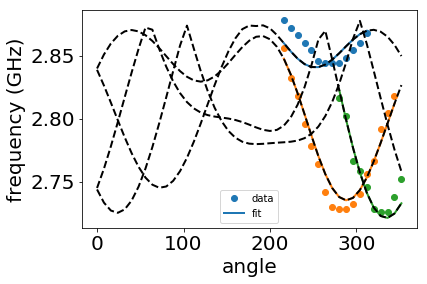

In [395]:

# initial_guess = {
#     'particle_radius':(17,5),
#     'nv_radius':(70,5),
#     'nv_x':(0,5),
#     'nv_y':(0,5),
#     'theta_mag':(120,45),
#     'phi_mag':(125,180),
#     'dipole_height':(50,30)
# }
# print('------=======------')
# # result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True)
# fit_result, result = fit_arc(angles=angles, data=data, initial_guess=initial_guess, transition=0, verbose=True,
#                  fit_parameter_keys=fit_parameter_keys)
# # figure out if we recieved just a single set or several datasets
# is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False



# for i, (d, a) in enumerate(zip(data, angles)):
#     y = np.tile(d,4).reshape(-1, len(d)).T

#     label='data' if i==0 else None 
#     plt.plot(a, d, 'o', label=label)

#     label='fit' if i==0 else None
    
    
#     y_pred = esr_ring_scan_freqs(a, *result.x)[:,:,transition]*1e-9
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     plt.plot(a, y_pred[:,idx], 'b-', label=label)
    
#     param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
#     idx = np.sum((y_pred-y)**2, axis=0).argmin()
#     label='initial' if i==0 else None
#     plt.plot(a, y_pred[:,idx], 'g--', label=label)
    
# colors = []



for i, (d, a) in enumerate(zip(data, angles)):
    label='data' if i==0 else None
    p = plt.plot(a, d, 'o', label=label)
    colors.append(p[0].get_color())

err, freqs, ids = loss_arcs(best_fit_params, angles, data, transition=0)
for i, (f, a, c) in enumerate(zip(freqs, angles, colors)):
    label='fit' if i==0 else None
    p = plt.plot(a, f, c, label=label)
    
# err, freqs_0, ids = loss_arcs({k:v for k, v in zip(initial_guess.keys(), param_init)}, angles, data, transition=0)
# for i, (f, a) in enumerate(zip(freqs_0, angles)):
#     label='initial' if i==0 else None
#     p = plt.plot(a, f, 'k--', label=label)
    
    
    
plt.legend()
plt.xlabel('angle')
plt.ylabel('frequency (GHz)')



# esr_pred = esr_ring_scan_freqs(angle, *result.x)[:,:,0]*1e-9
# for d in esr_pred.T:
#     plt.plot(angle, d, 'k--')

esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(angle, d, 'k--')
    

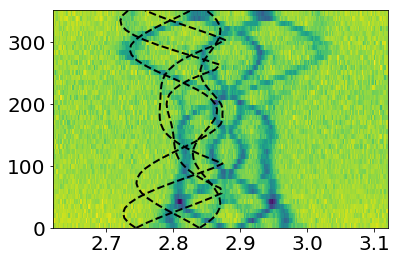

In [402]:
plt.pcolor(frequencies*1e-9, angle, esr_map)
esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9
for d in esr_pred.T:
    plt.plot(d, angle, 'k--')

In [383]:
esr_pred = esr_ring_scan_freqs(angle, **best_fit_params)[:,:,0]*1e-9

In [142]:

param_init = [v[0] if type(v) in (tuple, list) else v for v in initial_guess.values()]
df =pd.DataFrame.from_dict({
    'parameter set': ['initial guess'],
    **{k:[v] for k, v in sorted(zip(initial_guess.keys(), param_init))}
})
df = df.append(
    pd.DataFrame.from_dict({
    'parameter set': ['fit'],
    **{k:[v] for k, v in sorted(fit_result.items())}
}))
df

,parameter set,dipole_height,nv_radius,nv_x,nv_y,particle_radius,phi_mag,theta_mag
0,initial guess,50.0,70.0,0,0,17.000000,125.000000,120.000000
0,fit,65.0,67.5,0,0,18.385634,138.272014,115.908384


In [145]:
err, freqs, ids = loss_arcs({k:v for k, v in zip(initial_guess.keys(), result.x)}, angles, data, transition=0)

{'particle_radius': 18.3856341742334,
 'nv_radius': 67.5,
 'theta_mag': 115.9083837739332,
 'phi_mag': 138.2720140526634,
 'dipole_height': 65.0,
 'nv_x': 0,
 'nv_y': 0}

In [118]:
c

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']